In [1]:
%run DL_func.ipynb

In [2]:
from sklearn.metrics import r2_score

The first step consists of generating the synthetic data. The data is generated from the graph shown belown. Z denotes the unobserved latent variables, Y is the target variable which will be assumed observed (i.e. in the cow/camel classification problem 'Y' will correspond to the label 'cow' / 'camel'). X is the observed features as is generated from Z via a neural network. In the cow / camel classification problem 'X' would correspond to the actual image. Finally, an environment variable E is introduced. The environment determines the mean of the gaussian distribution the Z's are drawn from. The generative process for each of the variables is as follows:

$$Z_1 = \mathcal{N}(E, \sigma=1)$$
$$Z_2 = \mathcal{N}(2E, \sigma=2)$$
$$Y = \mathcal{N}(\alpha_1 \cdot Z_1+\alpha_2 \cdot Z_2, \sigma=1)$$
$$Y = \mathcal{N}(\alpha_3 \cdot Y, \sigma=1)$$
$$X = g(Z_1, Z_2, Z_3)$$

Where g is a randomly initialized neural network. All of the alphas are in this case set to 1.

First off, the Y's and Z's are generated from 4 different environments. 1000 samples from each environment is drawn.

In [3]:
E_choice, Env, Y, Z = generate_z_and_y(np.array([0.2, 2, 3, 5]), 8000)

Samples from the generative process is shown in the below dataframe along with markers of which environment a sample was drawn from and the corresponding 'mean' of that environment.

In [4]:
df=pd.concat([p(Z), p(Y), p(Env), p(E_choice)],axis=1)
df.columns = ['Z1', 'Z2', 'Z3', 'Y', 'Env_mean', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
tdf=df
df.round(2)

,Z1,Z2,Z3,Y,Env_mean,Env,c
0,2.25,1.04,4.48,3.85,0.2,0,red
1,1.07,7.98,8.88,8.97,2.0,1,blue
2,0.00,1.15,0.64,0.75,0.2,0,red
3,1.59,5.72,7.86,6.04,3.0,2,green
4,0.39,0.40,2.70,1.18,0.2,0,red
...,...,...,...,...,...,...,...
7995,5.16,8.01,12.29,13.22,5.0,3,yellow
7996,1.40,3.44,3.96,4.66,0.2,0,red
7997,0.26,1.48,2.38,2.47,0.2,0,red
7998,1.15,3.78,3.51,5.01,2.0,1,blue


Figure x shows a 3d-plot of the samples in (Z1, Z2, Z3)-space coloured by environment.

C:\Users\mathi\AppData\Local\Temp/ipykernel_19528/3887001011.py:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


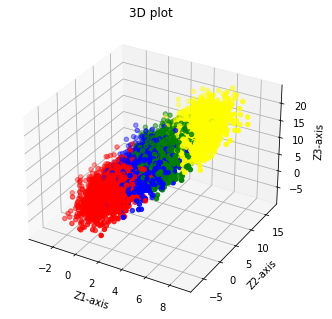

In [5]:
# for creating a responsive plot
#%matplotlib qt
%matplotlib inline

plot_latent_3d(df, m)

Finally, the observed X-values are generated via a randomly initialized neural network with 6 hidden units and 10 output units.

In [48]:
net=Net(3, 6, 10)
X=net(torch.from_numpy(Z.astype("float32"))).detach().numpy()
net1=Net1(3, 6, 10)
X1=net1(torch.from_numpy(Z.astype("float32"))).detach().numpy()

In [34]:
print(np.mean(X,axis=0))
print(np.mean(X1, axis=0))
print('\n')
print(np.var(X,axis=0))
print(np.var(X1, axis=0))

[-1.6616076  -0.13403277  2.1341891   1.1546534   0.2538534   0.4703996
 -0.4190928  -0.75566405 -1.7357236  -0.12399673]
[-0.8047818 -4.717243  -2.575232   5.981386   1.4913062 -2.3030715
 -4.9160686 -1.115882  -3.253088  -2.7794619]


[0.80018437 0.11465517 1.0739377  0.2777242  0.02993268 0.11212484
 0.00472662 0.56302816 1.1901573  0.06234397]
[ 0.21500343  9.233451    4.013981   19.586727    1.86428     3.056514
 12.025369    0.8516624   4.775628    3.2520373 ]


In [49]:
dset = EnvDataset(X[:4000],Y[:4000],E_choice[:4000])
train_loader = DataLoader(dset, batch_size=128, drop_last=True)
dset = EnvDataset(X[4000:],Y[4000:],E_choice[4000:])
test_loader = DataLoader(dset, batch_size=128, drop_last=True)
x,y,e = next(iter(train_loader))

In [50]:
import pdb
class iCARL(nn.Module):
    def __init__(self, x, y, e, input_size, output_size, input_size_de, output_size_de, input_size_pr, output_size_pr, y_dim, beta=1):
        super().__init__()
        # Encoder
        self.func_en = nn.Sequential(
                nn.Linear(in_features=input_size, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=2*output_size)
            )
        
                # Decoder
        self.func_de = nn.Sequential(
                nn.Linear(in_features=input_size_de, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=output_size_de)
            )
        
        # Prior
        self.TNN = nn.Sequential(
            nn.Linear(in_features=input_size_de, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=y_dim)
        )
        
        self.lambdaNN = nn.Sequential(
            nn.Linear(in_features=ye_dim, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=y_dim)
        )
        
        self.lambdaf = nn.Sequential(
            nn.Linear(in_features=ye_dim, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=input_size_de*2*2)
        )
        
        self.normal_dist = Normal_dist()
        
        
    
    def forward(self, x, y, e, beta=1):
        # Format input
        xye=torch.cat((x, y, e), 1)
        
        # Get encoder params
        z_usigma = self.func_en(xye)
        zu, zsigma = z_usigma.chunk(2, dim = -1) # Get mu and sigma
        zsigma = zsigma.exp()
        encoder_params = zu, zsigma

        # Sample Z
        z = self.normal_dist.sample(zu, zsigma)

        # Get decoder params
        de_u = self.func_de(z)
        
        # Get prior params
        #ye = torch.cat((y, e), 1)
        #prior_u, prior_sigma = self.func(ye).chunk(2, axis = -1)
        #prior_sigma = prior_sigma.exp()
        
        return zu, zsigma, de_u, z
    
    def elbo(self, x, y, e, beta=1):
        # Get encoder and decoder params
        zu, zsigma, de_u, z = self.forward(x, y, e)
        
        # Samples from distributions with the acquired parameters
        lvar = 0.01*torch.ones(1).to('cpu')
        log_px_z = self.normal_dist.log_pdf(x, de_u, lvar) # p(x | u, sigma)
        log_qz_xye = self.normal_dist.log_pdf(z, zu, zsigma)
        
        z_temp = z.detach().requires_grad_(requires_grad = True)
        
        # Get prior params
        ye = torch.cat((y.detach(),e.detach()),1)
        
        TNN_params = self.TNN(z_temp)#.chunk(2, axis = -1)
        lambdaNN_params = self.lambdaNN(ye)#.chunk(2, axis = -1)
        lambdaf_params, _ = self.lambdaf(ye).chunk(2, axis = -1)
        
        nn_ = (TNN_params*lambdaNN_params).sum(dim = 1)
        z_cat = torch.cat((z_temp, z_temp.pow(2)), dim = 1)
        f_ = (z_cat * lambdaf_params).sum(dim = 1)
        pz_ye = nn_ + f_
        
        dpz_ye = torch.autograd.grad(pz_ye.sum(), z_temp, create_graph = True, retain_graph = True)[0]
        ddpz_ye = torch.autograd.grad(dpz_ye.sum(), z_temp, create_graph = True, retain_graph = True)[0]
        
        SM = (ddpz_ye + 0.5 * dpz_ye.pow(2)).sum(1)

        elbo = log_px_z - log_qz_xye + pz_ye.detach()

        return elbo.mean()-SM.mean(), elbo.mean(), SM.mean()

    
    

In [51]:
z_dim = 3
x_y_e = 15
x_dim = 10
ye_dim = 5
y_dim = 1
net=iCARL(x.float(), y.float(), e.float(), x_y_e, z_dim, z_dim, x_dim, ye_dim, z_dim, y_dim, beta=1)

In [52]:
x,y,e = next(iter(train_loader))
elbo_SM, elbo, SM = net.elbo(x.float(),y.float(),e.float())

In [53]:
elbo_SM, elbo, SM

(tensor(-7642.6929, grad_fn=<SubBackward0>),
 tensor(-7636.3677, grad_fn=<MeanBackward0>),
 tensor(6.3250, grad_fn=<MeanBackward0>))

In [54]:
from torch.optim import Adam
optimizer = Adam(net.parameters(), lr=1e-3)

epochs = 200
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)

for epoch in range(epochs):
    epoch_loss = 0
    if epoch < 20:
        beta = 10
    else:
        beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss, elbo, SM = net.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)

Epoch 20 of 200
Train loss: tensor(43.5164)
Epoch 40 of 200
Train loss: tensor(-17.5011)
Epoch 60 of 200
Train loss: tensor(-73.2922)
Epoch 80 of 200
Train loss: tensor(-93.3293)
Epoch 100 of 200
Train loss: tensor(-107.0355)
Epoch 120 of 200
Train loss: tensor(-118.3669)
Epoch 140 of 200
Train loss: tensor(-130.3151)
Epoch 160 of 200
Train loss: tensor(-139.5216)
Epoch 180 of 200
Train loss: tensor(-140.3775)
Epoch 200 of 200
Train loss: tensor(-126.1093)


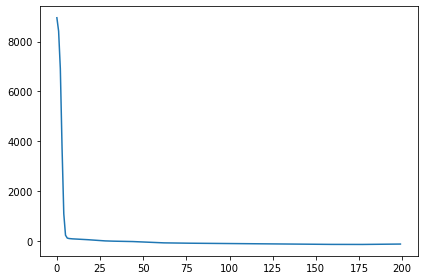

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_loss)
plt.show()

In [56]:
# get z
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 3))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0
for x,y,e in loader:
    _, _, _, z = net.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach()
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
    i+=1

In [57]:
df=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
df.columns = ['Z1', 'Z2', 'Z3', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
#df.round(2)

In [58]:
df

,Z1,Z2,Z3,Env,c
0,3.880073,4.590574,-2.769110,1,blue
1,6.411018,9.514795,-5.599422,2,green
2,4.117782,-1.085227,3.494107,0,red
3,12.522145,10.874624,-8.642288,3,yellow
4,1.113784,-0.552404,-0.958945,0,red
...,...,...,...,...,...
3963,1.233063,0.231757,2.206922,0,red
3964,11.992927,12.562339,-9.223500,3,yellow
3965,10.267379,9.415554,-7.331256,2,green
3966,8.688654,8.658026,-5.974772,3,yellow


In [45]:
%matplotlib qt
plot_latent_3d(df, m)

In [59]:
pdf=df[['Z1', 'Z2', 'Z3']]
pdf.columns = ['pZ1', 'pZ2', 'pZ3']
cdf=tdf[['Z1', 'Z2', 'Z3']].iloc[4000:7968,:]
#cdf=tdf[['Z1', 'Z2', 'Z3']].iloc[:1920,:]
cdf['pZ1']=pdf['pZ1'].values
cdf['pZ2']=pdf['pZ2'].values
cdf['pZ3']=pdf['pZ3'].values

corrs=cdf.corr().iloc[:3,3:]
mcc=corrs.max().mean()
mcc_abs=np.abs(corrs.max()).mean()
mcc, mcc_abs

(0.3745487100832274, 0.8970490044490318)

In [60]:
corrs

,pZ1,pZ2,pZ3
Z1,0.866033,0.835828,-0.783750
Z2,0.930171,0.874396,-0.971823
Z3,0.897420,0.977226,-0.977523


In [20]:
import pingouin as pg
from sklearn.linear_model import LinearRegression
df['Y']=Y[4000:7968]

dfc=pd.concat([df,pd.get_dummies(df['Env'],drop_first=True)],axis=1)
dfc['Z1x_1']=dfc['Z1']*dfc[1]
dfc['Z1x_2']=dfc['Z1']*dfc[2]
dfc['Z1x_3']=dfc['Z1']*dfc[3]
dfc['Z2x_1']=dfc['Z2']*dfc[1]
dfc['Z2x_2']=dfc['Z2']*dfc[2]
dfc['Z2x_3']=dfc['Z2']*dfc[3]
dfc['Z3x_1']=dfc['Z3']*dfc[1]
dfc['Z3x_2']=dfc['Z3']*dfc[2]
dfc['Z3x_3']=dfc['Z3']*dfc[3]
train=dfc.iloc[:1600,:]
test=dfc.iloc[:1600,:]

C:\Users\mathi\anaconda3\envs\BackDec2022\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\mathi\anaconda3\envs\BackDec2022\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [21]:
def predict_y(df, x_train, y_train, x_test, y_test, linear=True):
    if linear:
        lm = pg.linear_regression(x_train,y_train)#, add_intercept=False)
        print(lm)
        reg = LinearRegression().fit(x_train, y_train)
        y_pred = reg.predict(x_test)
        print(r2_score(y_pred, y_test))
        
        return y_pred
    
    

In [22]:
train=df.iloc[:4000,:]
test=df.iloc[:4000,:]

In [23]:
y_pred=predict_y(dfc, train[['Z1', 'Z2', 'Z3']], train['Y'], test[['Z1', 'Z2', 'Z3']], test['Y'])
#y_pred=predict_y(dfc, train[['Z1', 'Z2', 1, 2, 3, 'Z1x_1', 'Z1x_2', 'Z1x_3', 'Z2x_1', 'Z2x_2', 'Z2x_3']],
#                 train['y'], test[['Z1', 'Z2', 1, 2, 3, 'Z1x_1', 'Z1x_2', 'Z1x_3', 'Z2x_1', 'Z2x_2', 'Z2x_3']],
#                 test['y'])
y_pred=predict_y(dfc, train[['Z1', 'Z2']], train['Y'], test[['Z1', 'Z2']], test['Y'])
y_pred=predict_y(dfc, train[['Z3']], train['Y'], test[['Z3']], test['Y'])

       names      coef        se           T          pval        r2   adj_r2  \
0  Intercept  0.274220  0.022973   11.936380  2.717841e-32  0.977597  0.97758   
1         Z1 -0.504751  0.001742 -289.786937  0.000000e+00  0.977597  0.97758   
2         Z2  0.000011  0.000012    0.856935  3.915324e-01  0.977597  0.97758   
3         Z3  0.018732  0.002813    6.658694  3.141782e-11  0.977597  0.97758   

   CI[2.5%]  CI[97.5%]  
0  0.229179   0.319261  
1 -0.508166  -0.501336  
2 -0.000014   0.000035  
3  0.013217   0.024247  
0.9770836163140894
       names      coef        se           T          pval        r2  \
0  Intercept  0.238232  0.022450   10.611475  5.857257e-26  0.977346   
1         Z1 -0.496306  0.001200 -413.474830  0.000000e+00  0.977346   
2         Z2  0.000011  0.000012    0.851922  3.943087e-01  0.977346   

     adj_r2  CI[2.5%]  CI[97.5%]  
0  0.977335  0.194216   0.282247  
1  0.977335 -0.498659  -0.493952  
2  0.977335 -0.000014   0.000035  
0.9768213620129248
  

In [24]:
graphdf=df[['Z1', 'Z2', 'Z3', 'Y']]

In [25]:
graphdf.values

array([[   -9.21496105,  1537.8248291 ,    -6.31080675,     5.89806828],
       [  -18.41837692,  -619.61102295,   -16.56521416,    10.21227467],
       [    2.68889832,   333.31188965,    -3.41897297,    -2.70465302],
       ...,
       [  -24.58221245, -1082.27697754,   -13.5813942 ,    12.90595878],
       [  -21.81904411,   471.85229492,   -10.54393291,    10.23255302],
       [  -24.12418747,   724.88287354,   -18.07155037,    12.12180436]])

In [26]:
from causallearn.utils.cit import CIT
kci_obj = CIT(graphdf.values, "kci") 
kci_obj(0,1, {2})
#pE = kci_obj(0, 1, {3})
#pYE = kci_obj(0, 1, {2, 3})

0.0

  0%|          | 0/4 [00:00<?, ?it/s]

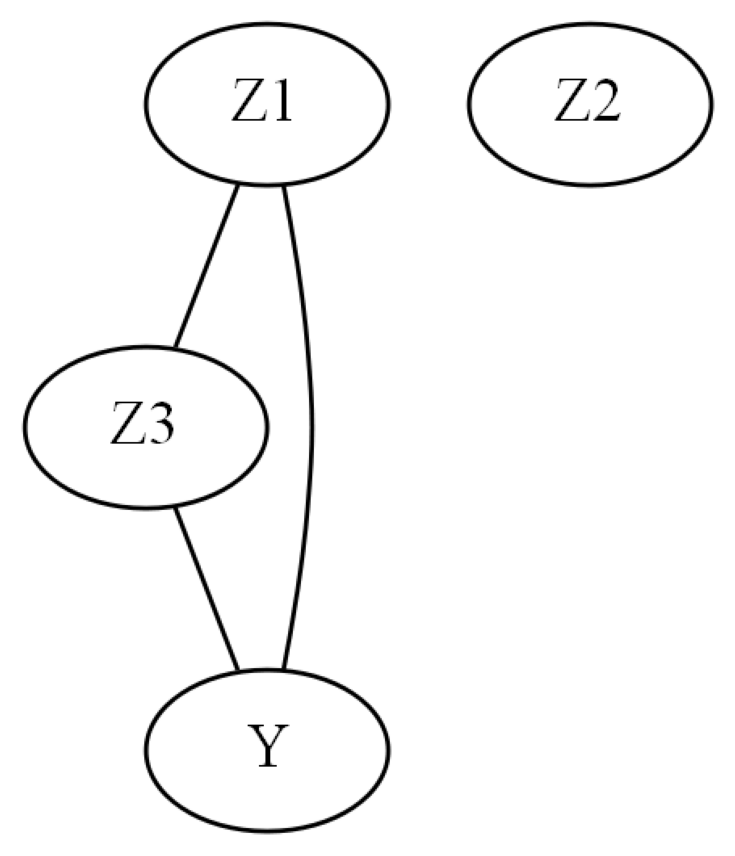

In [27]:
%matplotlib inline
from causallearn.search.ConstraintBased.PC import pc   
cg = pc(graphdf.values, 0.05)
# visualization using pydot
cg.draw_pydot_graph(labels = graphdf.columns)